In [206]:
import numpy as np
import s3fs
import requests
import pandas as pd
import zipfile
import io
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

In [33]:
def print_csv_names(bucket_name, file_name):
    path_to_file = f'../data/{bucket_name}/{file_name}'
    zip_file = zipfile.ZipFile(path_to_file)
    fs = {month: {} for month in month_list}
    zip_file.printdir()
    print('\n')
    for text_file in zip_file.infolist():
        if text_file.filename.endswith('.csv'):
            print(text_file.filename)

In [34]:
print_csv_names('tripdata', '2013-citibike-tripdata.zip')

File Name                                             Modified             Size
2013-citibike-tripdata/                        2024-02-22 00:06:56            0
2013-citibike-tripdata/4_April/                2024-02-14 10:09:16            0
2013-citibike-tripdata/12_December/            2024-02-22 00:03:04            0
2013-citibike-tripdata/.DS_Store               2024-02-22 00:07:16        12292
__MACOSX/2013-citibike-tripdata/._.DS_Store    2024-02-22 00:07:16          120
2013-citibike-tripdata/201309-citibike-tripdata.csv 2014-03-27 23:40:34    201965642
__MACOSX/2013-citibike-tripdata/._201309-citibike-tripdata.csv 2014-03-27 23:40:34          276
2013-citibike-tripdata/11_November/            2024-02-22 00:03:00            0
2013-citibike-tripdata/7_July/                 2024-02-22 00:02:38            0
2013-citibike-tripdata/201311-citibike-tripdata.csv 2014-03-27 23:43:44    131891356
__MACOSX/2013-citibike-tripdata/._201311-citibike-tripdata.csv 2014-03-27 23:43:44          27

In [48]:
def get_test_data():
    with zipfile.ZipFile('../data/tripdata/2013-citibike-tripdata.zip', 'r') as zip_file:
        month_df = pd.read_csv(zip_file.open('2013-citibike-tripdata/6_June/201306-citibike-tripdata_1.csv'), encoding='latin-1')
    return month_df

In [49]:
test_df = get_test_data()

In [57]:
test_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,16649,Subscriber,1984.0,1
2,2059,2013-06-01 00:00:44,2013-06-01 00:35:03,406,Hicks St & Montague St,40.695128,-73.995951,406.0,Hicks St & Montague St,40.695128,-73.995951,19599,Customer,NaN,0
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,E 15 St & Irving Pl,40.735243,-73.987586,262.0,Washington Park,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,Little West St & 1 Pl,40.705693,-74.016777,310.0,State St & Smith St,40.689269,-73.989129,15567,Subscriber,1983.0,1


In [113]:
test_df.dtypes
test_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577703 entries, 0 to 577702
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   tripduration             577703 non-null  int64         
 1   starttime                577703 non-null  datetime64[ns]
 2   stoptime                 577703 non-null  datetime64[ns]
 3   start station id         577703 non-null  int64         
 4   start station name       577703 non-null  object        
 5   start station latitude   577703 non-null  float64       
 6   start station longitude  577703 non-null  float64       
 7   end station id           559644 non-null  float64       
 8   end station name         559644 non-null  object        
 9   end station latitude     559644 non-null  float64       
 10  end station longitude    559644 non-null  float64       
 11  bikeid                   577703 non-null  int64         
 12  usertype        

In [130]:
test_df['starttime'] = pd.to_datetime(test_df['starttime'])
test_df['stoptime'] = pd.to_datetime(test_df['stoptime'])

test_df['usertype'] = test_df['usertype'].astype('category')
test_df['start station name'] = test_df['start station name'].astype('category')
test_df['end station name'] = test_df['end station name'].astype('category')
test_df['gender'] = test_df['gender'].astype('category')
for column in test_df.columns:
    if test_df[column].dtype == 'int64':
        test_df[column] = pd.to_numeric(test_df[column], downcast='integer')
    elif test_df[column].dtype == 'float64':#
        test_df[column] = pd.to_numeric(test_df[column], downcast='float')


In [116]:
test_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,16649,Subscriber,1984.0,1
2,2059,2013-06-01 00:00:44,2013-06-01 00:35:03,406,Hicks St & Montague St,40.695128,-73.995951,406.0,Hicks St & Montague St,40.695128,-73.995951,19599,Customer,NaN,0
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,E 15 St & Irving Pl,40.735243,-73.987586,262.0,Washington Park,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,Little West St & 1 Pl,40.705693,-74.016777,310.0,State St & Smith St,40.689269,-73.989129,15567,Subscriber,1983.0,1


In [131]:
test_df.dtypes
test_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577703 entries, 0 to 577702
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   tripduration             577703 non-null  int32         
 1   starttime                577703 non-null  datetime64[ns]
 2   stoptime                 577703 non-null  datetime64[ns]
 3   start station id         577703 non-null  int16         
 4   start station name       577703 non-null  category      
 5   start station latitude   577703 non-null  float32       
 6   start station longitude  577703 non-null  float32       
 7   end station id           559644 non-null  float32       
 8   end station name         559644 non-null  category      
 9   end station latitude     559644 non-null  float32       
 10  end station longitude    559644 non-null  float32       
 11  bikeid                   577703 non-null  int16         
 12  usertype        

# I only extract the monthly csv data, e.g. 
### 2013-citibike-tripdata/10_October/201310-citibike-tripdata_1.csv and 
### 2013-citibike-tripdata/10_October/201310-citibike-tripdata_2.csv
### for October

In [201]:
# Functions to load and process data

month_list = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar', 'April': 'Apr', 'May': 'May', 'June': 'Jun', 
              'July': 'Jul', 'August': 'Aug', 'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}

# Input: path or buffer
# Output: dataframe holding all trip data for a whole year
def process_citibike_zip_file(input_path) -> pd.DataFrame:
    # Construct output dictionary
    dataframes = []
    with zipfile.ZipFile(input_path, 'r') as zip_file:
        for text_file in zip_file.infolist():
            cur_filename = text_file.filename
            if cur_filename.endswith('.csv') and not cur_filename.startswith('__MACOSX'):
                dir_names = text_file.filename.split('/')
                
                if len(dir_names) == 3:
                        year = dir_names[0].split('-')[0]
                        month = dir_names[1].split('_')[1]
                        if month in month_list:
                            print(f'Processing {year} {month}: {dir_names[2]}')
                            # encoding utf-8 results in UnicodeDecodeError, see:
                            # https://stackoverflow.com/questions/5552555/unicodedecodeerror-invalid-continuation-byte
                            month_df = pd.read_csv(zip_file.open(text_file.filename), encoding='latin-1')

                            # Memory optimizations
                            month_df['starttime'] = pd.to_datetime(month_df['starttime'])
                            month_df['stoptime'] = pd.to_datetime(month_df['stoptime'])
                            month_df['gender'] = month_df['gender'].astype('category')
                            # Invalid birth years get convertet to NaN
                            month_df['birth year'] = pd.to_numeric(month_df['birth year'], errors='coerce', downcast='integer')
                            
                            for column in month_df.columns:
                                if month_df[column].dtype == 'int64':
                                    month_df[column] = pd.to_numeric(month_df[column], downcast='integer')
                                elif month_df[column].dtype == 'float64':
                                    month_df[column] = pd.to_numeric(month_df[column], downcast='float')
                                elif month_df[column].dtype == 'object':
                                    month_df[column] = month_df[column].astype('category')
                            month_df['month'] = month_list[month]
                            month_df['month'] = pd.Categorical(month_df['month'], categories=month_list.values(), ordered=True)
                            
                            dataframes.append(month_df)
                            # Per month there can be one or two CSV files
        
    total_rows = 0
    full_df = pd.concat(dataframes)

    print(f'Total no. of rows: {len(full_df.index)}')
    print(f'Memory usage:')
    print(full_df.info(memory_usage='deep'))
    
    return full_df

def process_nypd_data(input_path) -> pd.DataFrame:
    pass
    
# Citibike Data: Creates zipfile.Zipfile from csv.zip saved on local disk
# Tries to get csv from ../data/BUCKET_NAME/FILE_NAME.zip
def load_data_offline(bucket_name: str, file_name: str) -> pd.DataFrame:
    path_to_file = f'../data/{bucket_name}/{file_name}'
    if path_to_file.endswith('.zip'):
        return process_citibike_zip_file(path_to_file)
    elif path_to_file.endswith('.csv'):
        return process_nypd_xlsx(path_to_file)
        


# Citibike data: Creates zipfile.Zipfile from public access s3 URL
def load_data_online(bucket_name: str, file_name: str) -> pd.DataFrame:
    if file_name.endswith('.zip'):
        response = requests.get(f'https://s3.amazonaws.com/{bucket_name}/{file_name}')
        if response.status_code == 200:
            print("Successfully downloaded the zip file.")
            # Load the zip file into memory
            buffer = io.BytesIO(response.content)
            
            return process_citibike_zip_file(buffer)
        else:
            print(f'Http get request Error {response.status_code}')
    elif file_name.endswith('.xlsx'):
        url = 'https://data.cityofnewyork.us/api/views/h9gi-nx95/files/bd7ab0b2-d48c-48c4-a0a5-590d31a3e120?download=true&filename=MVCollisionsDataDictionary_20190813_ERD.xlsx'
        return process_nypd_xlsx(url)


def load_zip_csv(bucket_name: str, file_name: str) -> pd.DataFrame:
    try:
        print('Trying to load file from disk.')
        data = load_data_offline(bucket_name, file_name)
        print('Loaded file from disk.')

    except FileNotFoundError:
        print('Could not load from disk, loading from URL.')
        data = load_data_online(bucket_name, file_name)
        print('Loaded file from URL.')
        
    except:
        raise FileNotFoundError("Could not load file from disk or URL.")
        
    finally:
        return data


In [ ]:
# Functions to load and process NYPD data


In [202]:
data_2013 = load_zip_csv('tripdata', '2013-citibike-tripdata.zip')

Trying to load file from disk.
Processing 2013 December: 201312-citibike-tripdata_1.csv
Processing 2013 November: 201311-citibike-tripdata_1.csv
Processing 2013 July: 201307-citibike-tripdata_1.csv
Processing 2013 October: 201310-citibike-tripdata_2.csv
Processing 2013 October: 201310-citibike-tripdata_1.csv
Processing 2013 September: 201309-citibike-tripdata_2.csv
Processing 2013 September: 201309-citibike-tripdata_1.csv
Processing 2013 August: 201308-citibike-tripdata_1.csv
Processing 2013 August: 201308-citibike-tripdata_2.csv
Processing 2013 June: 201306-citibike-tripdata_1.csv
Total no. of rows: 5614888
Memory usage:
<class 'pandas.core.frame.DataFrame'>
Index: 5614888 entries, 0 to 577702
Data columns (total 16 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             int32         
 1   starttime                datetime64[ns]
 2   stoptime                 datetime64[ns]
 3   start station id         int16   

In [203]:
data_2014 = load_zip_csv('tripdata', '2014-citibike-tripdata.zip')

Trying to load file from disk.
Processing 2014 April: 201404-citibike-tripdata_1.csv
Processing 2014 December: 201412-citibike-tripdata_1.csv
Processing 2014 November: 201411-citibike-tripdata_1.csv
Processing 2014 July: 201407-citibike-tripdata_1.csv
Processing 2014 October: 201410-citibike-tripdata_1.csv
Processing 2014 September: 201409-citibike-tripdata_1.csv
Processing 2014 August: 201408-citibike-tripdata_1.csv
Processing 2014 June: 201406-citibike-tripdata_1.csv
Processing 2014 March: 201403-citibike-tripdata_1.csv
Processing 2014 January: 201401-citibike-tripdata_1.csv
Processing 2014 February: 201402-citibike-tripdata_1.csv
Processing 2014 May: 201405-citibike-tripdata_1.csv
Total no. of rows: 8081216
Memory usage:
<class 'pandas.core.frame.DataFrame'>
Index: 8081216 entries, 0 to 866116
Data columns (total 16 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             int32         
 1   starttime          

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
month,,,,,,,,,,,,,,,
Aug,1001958,1001958,1001958,1001958,1001958,1001958,1001958,1001958,1001958,1001958,1001958,1001958,1001958,1001958,1001958
Dec,443966,443966,443966,443966,443966,443966,443966,443966,443966,443966,443966,443966,443966,443966,443966
Jul,843416,843416,843416,843416,843416,843416,843416,843416,843416,843416,843416,843416,843416,843416,843416
Jun,577703,577703,577703,577703,577703,577703,577703,559644,559644,559644,559644,577703,577703,337382,577703
Nov,675774,675774,675774,675774,675774,675774,675774,675774,675774,675774,675774,675774,675774,675774,675774
Oct,1037712,1037712,1037712,1037712,1037712,1037712,1037712,1037712,1037712,1037712,1037712,1037712,1037712,1037712,1037712
Sep,1034359,1034359,1034359,1034359,1034359,1034359,1034359,1034359,1034359,1034359,1034359,1034359,1034359,1034359,1034359


In [167]:
def plot_tripcount_monthly(year: str, year_dict: dict):
    month_counts = year_dict['month'].value_counts().sort_index()
    fig = plt.figure(figsize = (10, 5))
    month_counts.plot(kind='bar', width=0.7)
    # creating the bar plot
    
    plt.xlabel("month")
    plt.ylabel("No. of trips")
    plt.title(f"Citibike Total Trips per Month in {year_dict}")
    plt.show()

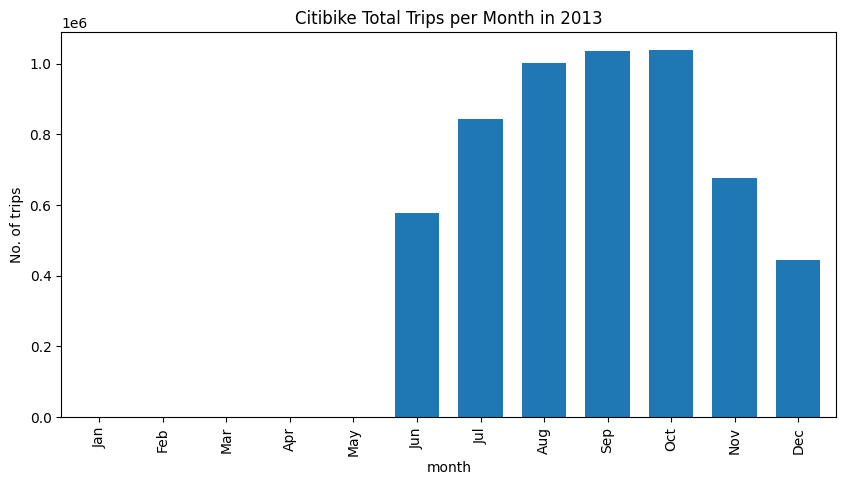

In [168]:
plot_tripcount_monthly('2013', data_2013)

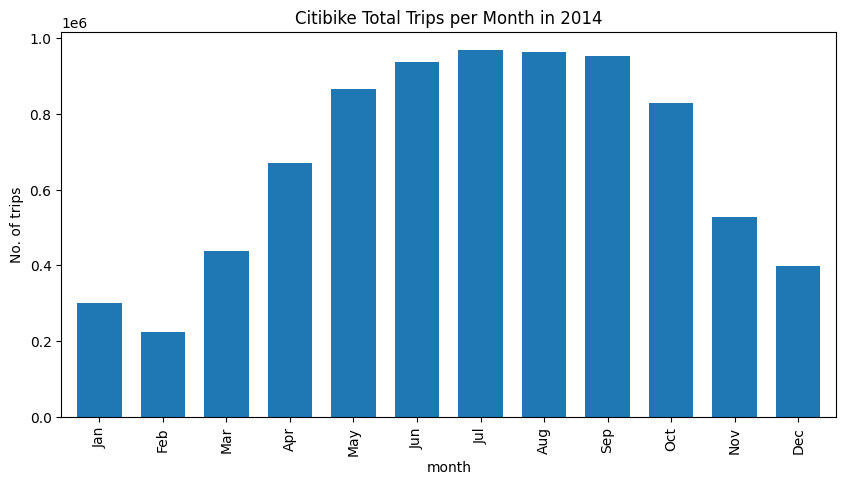

In [169]:
plot_tripcount_monthly('2014', data_2014)

In [173]:
data_2014['start station name'].value_counts()

start station name
8 Ave & W 31 St             100498
Lafayette St & E 8 St        86692
E 17 St & Broadway           80166
W 21 St & 6 Ave              73448
Broadway & E 14 St           65852
                             ...  
W 13 St & 5 Ave                989
Railroad Ave & Kay Ave         843
Church St & Leonard St         710
Montague St & Clinton St       486
7 Ave & Farragut St            457
Name: count, Length: 344, dtype: int64

,start station name,start station latitude,start station longitude,count
0,1 Ave & E 15 St,40.732220,-73.981659,49487
1,1 Ave & E 18 St,40.734161,-73.980240,23822
2,1 Ave & E 30 St,40.741444,-73.975357,33802
3,1 Ave & E 44 St,40.750019,-73.969055,19237
4,10 Ave & W 28 St,40.750664,-74.001770,29677
...,...,...,...,...
340,Willoughby Ave & Hall St,40.691959,-73.965370,7357
341,Willoughby Ave & Walworth St,40.693317,-73.953819,4936
342,Willoughby St & Fleet St,40.691967,-73.981300,8216
343,Wythe Ave & Metropolitan Ave,40.716888,-73.963196,15214


In [176]:
print(data_2014.groupby('start station name')["start station latitude"])

In [189]:
# If month is not specified, plot over whole year
def plot_triphour(year: str, df: dict):
    df_count = df["starttime"].groupby(df["starttime"].dt.hour).count()
    df_count.plot(kind="bar",  figsize=(10, 5), ylabel='count')

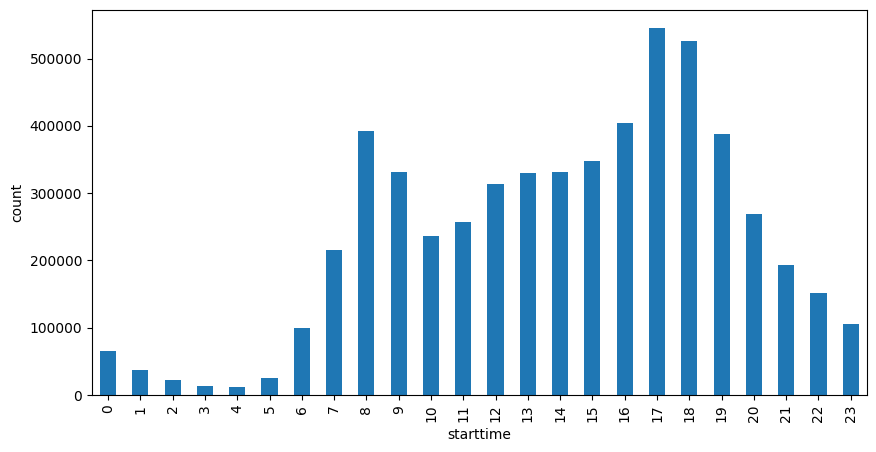

In [190]:
plot_triphour('2013', data_2013)

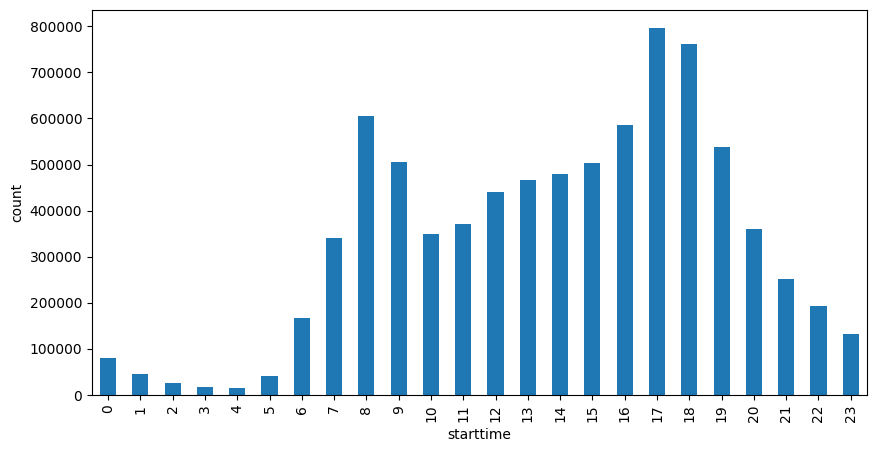

In [191]:
plot_triphour('2014', data_2014)

In [211]:
def plot_age_distribution(year, df):
    df['age'] = int(year) - df['birth year']
    fig = plt.figure(figsize = (10, 5))
    df['age'].plot(kind='hist', bins=20, density=True, color='skyblue', edgecolor='black', alpha=0.7)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    plt.title(f'Relative Age Distribution {year}', fontsize=16)
    plt.xlabel('Age', fontsize=14)
    plt.ylabel('Relative Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()
    
def plot_age_distribution_kde(year, df):
    df['age'] = int(year) - df['birth year']
    fig = plt.figure(figsize = (10, 5))

    ax = sns.kdeplot(df['age'], fill=True, color='skyblue')

    # Convert density to percentage on the y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
    
    # Customize the plot
    plt.title('Relative Age Distribution (KDE)', fontsize=16)
    plt.xlabel('Age', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

NameError: name 'ax' is not defined

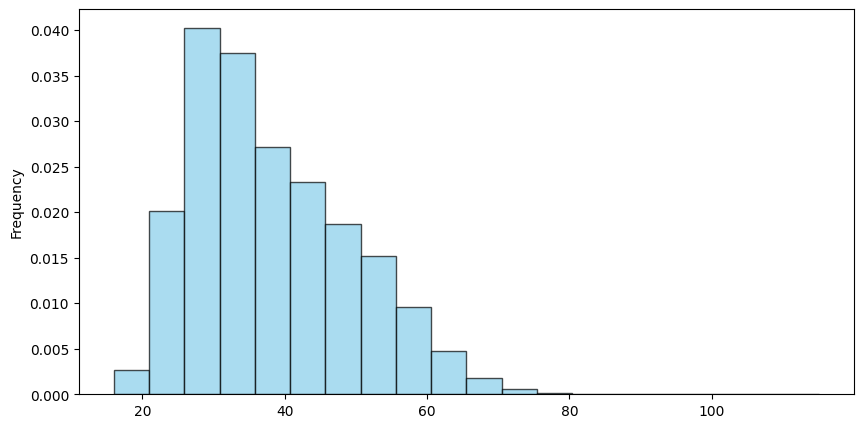

In [212]:
plot_age_distribution('2014', data_2014)

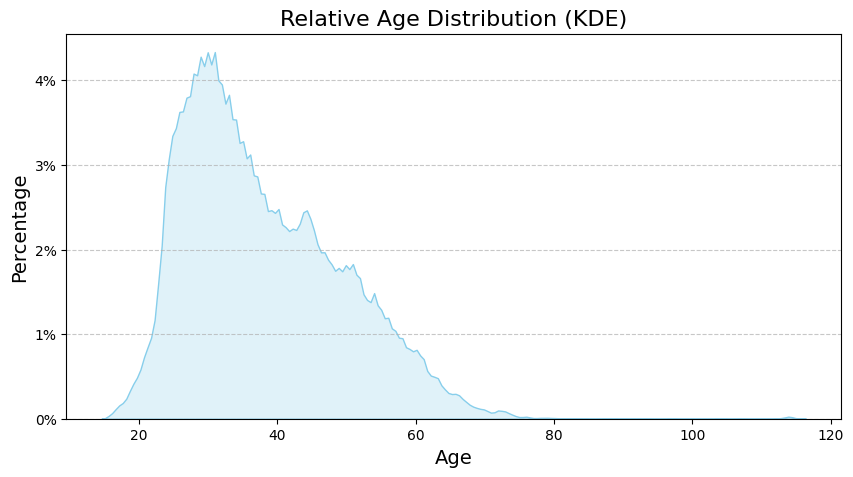

In [210]:
plot_age_distribution_kde('2014', data_2014)

In [193]:
station_counts = data_2014.groupby(['start station name', "start station latitude", "start station longitude"]).size().reset_index(name='count')
print(station_counts)

               start station name  start station latitude  \
0                 1 Ave & E 15 St               40.732220   
1                 1 Ave & E 18 St               40.734161   
2                 1 Ave & E 30 St               40.741444   
3                 1 Ave & E 44 St               40.750019   
4                10 Ave & W 28 St               40.750664   
..                            ...                     ...   
340      Willoughby Ave & Hall St               40.691959   
341  Willoughby Ave & Walworth St               40.693317   
342      Willoughby St & Fleet St               40.691967   
343  Wythe Ave & Metropolitan Ave               40.716888   
344              York St & Jay St               40.701485   

     start station longitude  count  
0                 -73.981659  49487  
1                 -73.980240  23822  
2                 -73.975357  33802  
3                 -73.969055  19237  
4                 -74.001770  29677  
..                       ...    ...  
3

In [183]:
import plotly.io as pio
pio.renderers.default = 'iframe'
color_scale = [(0, 'orange'), (1,'red')]
fig = px.scatter_mapbox(station_counts, 
                        lat="start station latitude", 
                        lon="start station longitude", 
                        hover_name='start station name', 
                        hover_data=['start station name', 'count'],
                        color="count",
                        color_continuous_scale=color_scale,
                        size="count",
                        zoom=8, 
                        height=800,
                        width=800)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [44]:
#citibike_data_path = './data/citibike/'
#path_to_file = '2013-citibike-tripdata.zip'
#"C:\Users\Joris\Projects\coding-challenge-AXA\data\tripdata\2013-citibike-tripdata.zip"
load_zip_csv_offline('tripdata', '2013-citibike-tripdata.zip')
load_zip_csv_url('tripdata', '2013-citibike-tripdata.zip')

2013-citibike-tripdata/201309-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201309-citibike-tripdata.csv
2013-citibike-tripdata/201311-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201311-citibike-tripdata.csv
2013-citibike-tripdata/201307-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201307-citibike-tripdata.csv
2013-citibike-tripdata/201308-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201308-citibike-tripdata.csv
2013-citibike-tripdata/201306-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201306-citibike-tripdata.csv
2013-citibike-tripdata/201310-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201310-citibike-tripdata.csv
2013-citibike-tripdata/201312-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201312-citibike-tripdata.csv
2013-citibike-tripdata/12_December/201312-citibike-tripdata_1.csv
2013-citibike-tripdata/11_November/201311-citibike-tripdata_1.csv
2013-citibike-tripdata/7_July/201307-citibike-tripdata_1.csv
20

In [47]:
for i in range(0, 12):
    load_zip_csv_offline('tripdata', f'{2013 + i}-citibike-tripdata.zip')

2013-citibike-tripdata/201309-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201309-citibike-tripdata.csv
2013-citibike-tripdata/201311-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201311-citibike-tripdata.csv
2013-citibike-tripdata/201307-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201307-citibike-tripdata.csv
2013-citibike-tripdata/201308-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201308-citibike-tripdata.csv
2013-citibike-tripdata/201306-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201306-citibike-tripdata.csv
2013-citibike-tripdata/201310-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201310-citibike-tripdata.csv
2013-citibike-tripdata/201312-citibike-tripdata.csv
__MACOSX/2013-citibike-tripdata/._201312-citibike-tripdata.csv
2013-citibike-tripdata/12_December/201312-citibike-tripdata_1.csv
2013-citibike-tripdata/11_November/201311-citibike-tripdata_1.csv
2013-citibike-tripdata/7_July/201307-citibike-tripdata_1.csv
20

FileNotFoundError: [Errno 2] No such file or directory: '../data/tripdata/2024-citibike-tripdata.zip'